<a href="https://colab.research.google.com/github/LiYuan199701/TimeSeries/blob/Bayesian-single-perceptron-TS/AR1_BNAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoregressive weight Bayesian Neural Autoregression

- AR1: Highlights the core innovation - the AR(1) process on weights
- B: Bayesian - emphasizes the variational inference approach
- NAR: Neural Autoregression - indicates it's a neural network approach for autoregressive modeling

# Imports and configuration

In [1]:
# ===============================
# Bayesian single-perceptron NAR(d)
# with recency-decaying prior means
# ===============================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
# Set inline backend and resolution
%config InlineBackend.figure_format = 'retina'  # For Retina displays
plt.rcParams['figure.dpi'] = 150  # Set dpi to 200 for high resolution

torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate Simulated Nonlinear bounded Time Series

Text(0.5, 1.0, 'Bounded [-1,1] Time Series')

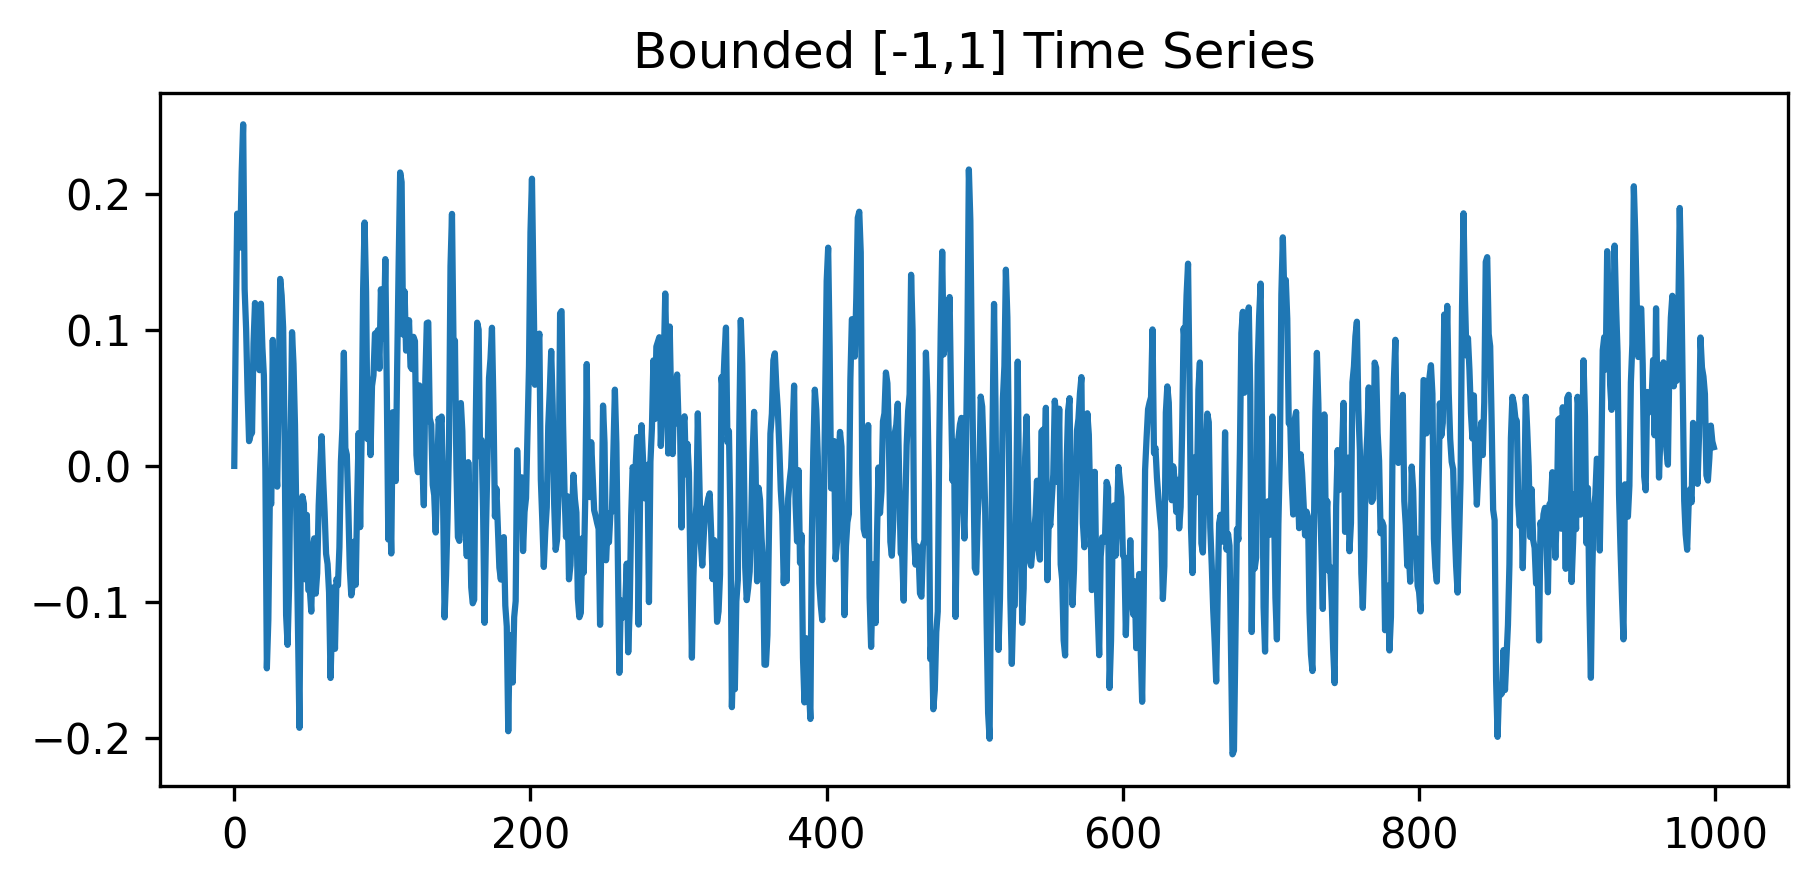

In [2]:
# -----------------------------
# 1) Simulate bounded time series
# -----------------------------
T = 1000
x = np.zeros(T)
x[0], x[1] = 0.0, 0.1
for t in range(2, T):
    x[t] = 0.7 * x[t-1] - 0.3 * x[t-2] + 0.1 * np.sin(3 * x[t-1]) + 0.05 * np.random.randn()
    x[t] = np.tanh(x[t])  # keep within [-1, 1]

# plot this time series
plt.figure(figsize=(7,3))
plt.plot(x)
plt.title("Bounded [-1,1] Time Series")

# Create lagged time series dataframe and tensor

In [3]:
# ---------------------------------
# 2) Build lagged features X_{t-1:t-d}
# ---------------------------------
def make_lagged(series, d):
    N = len(series) - d
    X = np.zeros((N, d), dtype=np.float32)
    y = np.zeros(N, dtype=np.float32)
    for i in range(N):
        # most recent first: [x_{t-1}, x_{t-2}, ..., x_{t-d}]
        X[i] = series[i:i+d][::-1]
        y[i] = series[i+d]
    return X, y

d = 4
X, y = make_lagged(x, d)
N = len(y)

# Train/val/test split by time
n_train = int(0.7*N)
n_val   = int(0.15*N)
idx_tr  = slice(0, n_train)
idx_va  = slice(n_train, n_train+n_val)
idx_te  = slice(n_train+n_val, N)

Xtr, ytr = X[idx_tr], y[idx_tr]
Xva, yva = X[idx_va], y[idx_va]
Xte, yte = X[idx_te], y[idx_te]

Xtr_t = torch.tensor(Xtr, dtype=torch.float32, device=device)
ytr_t = torch.tensor(ytr, dtype=torch.float32, device=device).unsqueeze(1)
Xva_t = torch.tensor(Xva, dtype=torch.float32, device=device)
yva_t = torch.tensor(yva, dtype=torch.float32, device=device).unsqueeze(1)
Xte_t = torch.tensor(Xte, dtype=torch.float32, device=device)
yte_t = torch.tensor(yte, dtype=torch.float32, device=device).unsqueeze(1)

# print shape and Xtr_t
print("Xtr_t shape:", Xtr_t.shape)
print(Xtr_t[:2])
print("ytr_t shape:", ytr_t.shape)
print(ytr_t[:2])
print("Xtr_t dtype:", Xtr_t.dtype)
print("Xtr_t device:", Xtr_t.device)

# form Xtr, ytr into a dataframe
df = pd.DataFrame(Xtr, columns=[f"x_{i}" for i in range(1, d+1)])
df["y"] = ytr
df.head()

Xtr_t shape: torch.Size([697, 4])
tensor([[0.1711, 0.1856, 0.1000, 0.0000],
        [0.1607, 0.1711, 0.1856, 0.1000]], device='cuda:0')
ytr_t shape: torch.Size([697, 1])
tensor([[0.1607],
        [0.2161]], device='cuda:0')
Xtr_t dtype: torch.float32
Xtr_t device: cuda:0


x_1       x_2       x_3       x_4         y
0  0.171057  0.185579  0.100000  0.000000  0.160692
1  0.160692  0.171057  0.185579  0.100000  0.216112
2  0.216112  0.160692  0.171057  0.185579  0.251333
3  0.251333  0.216112  0.160692  0.171057  0.129952
4  0.129952  0.251333  0.216112  0.160692  0.100734

# Define Model Class

## Define AR1_BNAR_diagonal

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class AR1_BNAR_diagonal(nn.Module):
    """
    Corrected version with proper AR(1) prior and KL divergence
    Adapted for the specific data format with most recent lag first
    """

    def __init__(self, d):
        super().__init__()
        self.d = d

        # Variational posterior parameters - initialize with reasonable scale
        self.m_w = nn.Parameter(torch.randn(d) * 0.1)
        self.log_s_w = nn.Parameter(torch.full((d,), math.log(0.1)))

        # Deterministic bias
        self.b = nn.Parameter(torch.tensor(0.0))

        # Observation noise
        self.log_sigma_eps = nn.Parameter(torch.tensor(math.log(0.1)))

        # Learnable AR(1) hyperparameters
        self.mu0 = nn.Parameter(torch.tensor(0.0))
        self.log_sigma0 = nn.Parameter(torch.tensor(math.log(0.5)))
        self.phi_raw = nn.Parameter(torch.tensor(0.5))
        self.log_sigma_w = nn.Parameter(torch.tensor(math.log(0.1)))

    def get_params(self):
        phi = torch.tanh(self.phi_raw)
        sigma0 = F.softplus(self.log_sigma0) + 1e-6
        sigma_w = F.softplus(self.log_sigma_w) + 1e-6
        sigma_eps = F.softplus(self.log_sigma_eps) + 1e-6
        return phi, sigma0, sigma_w, sigma_eps

    def build_ar1_covariance(self, phi, sigma0, sigma_w, device):
        """Build the full covariance matrix for AR(1) process"""
        # For your setup: w[0] -> x_{t-1} (most recent), w[1] -> x_{t-2}, etc.
        # So the AR(1) process goes: w_0 (most recent weight), w_1, w_2, w_3 (oldest weight)

        stationary_var = sigma_w**2 / (1 - phi**2 + 1e-8)

        cov = torch.zeros(self.d, self.d, device=device)

        for i in range(self.d):
            for j in range(self.d):
                k = abs(i - j)
                if i == 0 and j == 0:
                    cov[i, j] = sigma0**2
                else:
                    min_idx = min(i, j)
                    base_var = (phi**(2 * min_idx)) * sigma0**2 + \
                              stationary_var * (1 - phi**(2 * min_idx))
                    cov[i, j] = (phi**k) * base_var

        cov = cov + 1e-6 * torch.eye(self.d, device=device)
        return cov

    def kl_gaussian(self, mu_q, log_var_q, mu_p, cov_p):
        """
        Compute KL(q || p) where:
        q ~ N(mu_q, diag(exp(log_var_q)))
        p ~ N(mu_p, cov_p)
        """
        var_q = torch.exp(log_var_q)
        d = mu_q.shape[0]

        cov_p_reg = cov_p + 1e-6 * torch.eye(d, device=cov_p.device)
        L_p = torch.linalg.cholesky(cov_p_reg)

        # Term 1: Trace term
        Linv = torch.linalg.solve_triangular(L_p, torch.eye(d, device=cov_p.device), upper=False)
        precision_diag = torch.sum(Linv ** 2, dim=0)
        trace_term = torch.sum(var_q * precision_diag)

        # Term 2: Quadratic term
        diff = mu_q - mu_p
        quad_term = diff @ torch.cholesky_solve(diff.unsqueeze(1), L_p).squeeze()

        # Term 3: Log determinant term
        log_det_p = 2 * torch.sum(torch.log(torch.diag(L_p)))
        log_det_q = torch.sum(log_var_q)

        kl = 0.5 * (trace_term + quad_term - d + log_det_p - log_det_q)
        return kl

    def forward(self, X, sample=True, kl_weight=1.0):
        device = X.device
        phi, sigma0, sigma_w, sigma_eps = self.get_params()

        # Build AR(1) prior mean and covariance
        # For AR(1) process: E[w_k] = mu0 * phi^k
        mu_p = torch.stack([self.mu0 * (phi ** k) for k in range(self.d)]).to(device)
        cov_p = self.build_ar1_covariance(phi, sigma0, sigma_w, device)

        # Sample from variational posterior
        if sample and self.training:
            eps = torch.randn(self.d, device=device)
            w = self.m_w + torch.exp(0.5 * self.log_s_w) * eps
        else:
            w = self.m_w

        # Model prediction - X shape: (batch_size, d), w shape: (d,)
        # Result: (batch_size, 1) to match y shape
        yhat = torch.tanh( (X @ w).unsqueeze(1) + self.b )

        # KL divergence
        kl_w = self.kl_gaussian(self.m_w, self.log_s_w, mu_p, cov_p)

        return yhat, sigma_eps, kl_weight * kl_w

    def negative_elbo(self, X, y, kl_weight=1.0):
        """Compute negative ELBO for training"""
        yhat, sigma_eps, kl_term = self.forward(X, sample=True, kl_weight=kl_weight)

        # Log likelihood term (Gaussian)
        n = X.shape[0]
        log_likelihood = -0.5 * n * torch.log(2 * torch.tensor(math.pi) * sigma_eps ** 2) \
                         - 0.5 * torch.sum((y - yhat) ** 2) / (sigma_eps ** 2)

        negative_elbo = -log_likelihood + kl_term

        return negative_elbo, yhat

## Define AR1_BNAR_full

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class AR1_BNAR_full(nn.Module):
    """
    AR(1) Bayesian Nonlinear Autoregressive model
    with full-covariance variational posterior q(w) = N(m_w, L_q L_q^T).

    Compared to the diagonal-covariance version, this allows
    posterior correlations among weight dimensions.
    """

    def __init__(self, d):
        super().__init__()
        self.d = d

        # === Variational posterior parameters ===
        self.m_w = nn.Parameter(torch.randn(d) * 0.1)

        # Diagonal log-variances (for positive scaling on L_q's diagonal)
        self.log_diag_Lq = nn.Parameter(torch.full((d,), math.log(0.1)))

        # Strictly lower-triangular unconstrained elements (d*(d-1)/2)
        tril_indices = torch.tril_indices(row=d, col=d, offset=-1)
        self.Lq_offdiag = nn.Parameter(torch.zeros(tril_indices.shape[1]))

        # === Deterministic bias ===
        self.b = nn.Parameter(torch.tensor(0.0))

        # === Observation noise ===
        self.log_sigma_eps = nn.Parameter(torch.tensor(math.log(0.1)))

        # === AR(1) prior hyperparameters ===
        self.mu0 = nn.Parameter(torch.tensor(0.0))
        self.log_sigma0 = nn.Parameter(torch.tensor(math.log(0.5)))
        self.phi_raw = nn.Parameter(torch.tensor(0.5))
        self.log_sigma_w = nn.Parameter(torch.tensor(math.log(0.1)))

    # ---------------------------------------------------------------------
    def get_params(self):
        """Transform unconstrained parameters into valid AR(1) hyperparameters"""
        phi = torch.tanh(self.phi_raw)
        sigma0 = F.softplus(self.log_sigma0) + 1e-6
        sigma_w = F.softplus(self.log_sigma_w) + 1e-6
        sigma_eps = F.softplus(self.log_sigma_eps) + 1e-6
        return phi, sigma0, sigma_w, sigma_eps

    # ---------------------------------------------------------------------
    def build_ar1_covariance(self, phi, sigma0, sigma_w, device):
        """Build full AR(1) prior covariance Σ_p"""
        stationary_var = sigma_w**2 / (1 - phi**2 + 1e-8)
        cov = torch.zeros(self.d, self.d, device=device)
        for i in range(self.d):
            for j in range(self.d):
                k = abs(i - j)
                if i == 0 and j == 0:
                    cov[i, j] = sigma0**2
                else:
                    min_idx = min(i, j)
                    base_var = (phi**(2 * min_idx)) * sigma0**2 + \
                               stationary_var * (1 - phi**(2 * min_idx))
                    cov[i, j] = (phi**k) * base_var
        cov = cov + 1e-6 * torch.eye(self.d, device=device)
        return cov

    # ---------------------------------------------------------------------
    def get_Lq(self, device):
        """Construct lower-triangular Cholesky factor L_q with positive diagonal"""
        L_q = torch.zeros(self.d, self.d, device=device)
        tril_indices = torch.tril_indices(row=self.d, col=self.d, offset=-1)
        L_q[tril_indices[0], tril_indices[1]] = self.Lq_offdiag
        L_q = L_q + torch.diag(torch.exp(self.log_diag_Lq))
        return L_q

    # ---------------------------------------------------------------------
    def kl_gaussian_full(self, mu_q, L_q, mu_p, cov_p):
        """
        Compute KL(q || p) where:
        q ~ N(mu_q, L_q L_q^T)
        p ~ N(mu_p, cov_p)
        """
        d = mu_q.shape[0]
        cov_p_reg = cov_p + 1e-6 * torch.eye(d, device=cov_p.device)
        L_p = torch.linalg.cholesky(cov_p_reg)

        # Precision of prior Σ_p^{-1}
        Linv = torch.linalg.solve_triangular(L_p, torch.eye(d, device=cov_p.device), upper=False)
        Sigma_p_inv = Linv.T @ Linv

        # Compute Σ_q and terms
        Sigma_q = L_q @ L_q.T
        trace_term = torch.trace(Sigma_p_inv @ Sigma_q)

        diff = (mu_q - mu_p).unsqueeze(1)
        quad_term = (diff.T @ Sigma_p_inv @ diff).squeeze()

        log_det_p = 2 * torch.sum(torch.log(torch.diag(L_p)))
        log_det_q = 2 * torch.sum(torch.log(torch.diag(L_q)))

        kl = 0.5 * (trace_term + quad_term - d + log_det_p - log_det_q)
        return kl

    # ---------------------------------------------------------------------
    def forward(self, X, sample=True, kl_weight=1.0):
        device = X.device
        phi, sigma0, sigma_w, sigma_eps = self.get_params()

        # === AR(1) prior mean and covariance ===
        mu_p = torch.stack([self.mu0 * (phi ** k) for k in range(self.d)]).to(device)
        cov_p = self.build_ar1_covariance(phi, sigma0, sigma_w, device)

        # === Variational posterior sampling ===
        L_q = self.get_Lq(device)
        if sample and self.training:
            eps = torch.randn(self.d, device=device)
            w = self.m_w + L_q @ eps
        else:
            w = self.m_w

        # === Prediction ===
        yhat = torch.tanh((X @ w).unsqueeze(1) + self.b)

        # === KL divergence ===
        kl_w = self.kl_gaussian_full(self.m_w, L_q, mu_p, cov_p)
        return yhat, sigma_eps, kl_weight * kl_w

    # ---------------------------------------------------------------------
    def negative_elbo(self, X, y, kl_weight=1.0):
        """Compute the negative ELBO"""
        yhat, sigma_eps, kl_term = self.forward(X, sample=True, kl_weight=kl_weight)

        n = X.shape[0]
        log_likelihood = -0.5 * n * torch.log(2 * torch.tensor(math.pi) * sigma_eps ** 2) \
                         - 0.5 * torch.sum((y - yhat) ** 2) / (sigma_eps ** 2)
        negative_elbo = -log_likelihood + kl_term
        return negative_elbo, yhat

# Initial Model and Train

In [10]:
# ==========================================================
# Save L_q and Sigma_q at training time for visualization
# ==========================================================

def record_posterior_state(model, history_Lq, history_cov):
    device = next(model.parameters()).device

    # Extract posterior Cholesky factor
    L_q = model.get_Lq(device).detach().cpu().numpy()
    history_Lq.append(L_q)

    # Extract posterior covariance
    cov_q = (model.get_Lq(device) @ model.get_Lq(device).T).detach().cpu().numpy()
    history_cov.append(cov_q)

    return history_Lq, history_cov


Starting training...
Epoch    0: NELBO = -678.7759, Train RMSE = 0.0912, Val RMSE = 0.0819, φ = 0.461, σ_ε = 0.095
  Weights: [-0.10745224 -0.13885954  0.04133468  0.08480264]
  Weight stds: [0.31638592 0.3160697  0.31638592 0.3160697 ]
Epoch  200: NELBO = -858.1301, Train RMSE = 0.0684, Val RMSE = 0.0667, φ = 0.290, σ_ε = 0.083
Epoch  400: NELBO = -895.2608, Train RMSE = 0.0668, Val RMSE = 0.0571, φ = 0.197, σ_ε = 0.070
Epoch  600: NELBO = -987.1735, Train RMSE = 0.0586, Val RMSE = 0.0524, φ = 0.248, σ_ε = 0.061
  Weights: [ 0.42238086  0.18743378  0.0031977  -0.12297126]
  Weight stds: [0.30642283 0.29903805 0.28750518 0.26760516]
Epoch  800: NELBO = -1046.8418, Train RMSE = 0.0538, Val RMSE = 0.0493, φ = 0.187, σ_ε = 0.056
Epoch 1000: NELBO = -1072.9540, Train RMSE = 0.0518, Val RMSE = 0.0479, φ = 0.080, σ_ε = 0.053
Epoch 1200: NELBO = -1093.6831, Train RMSE = 0.0503, Val RMSE = 0.0469, φ = -0.010, σ_ε = 0.052
  Weights: [ 7.5109613e-01  1.5180582e-02 -1.3973930e-01  5.5520586e-04]

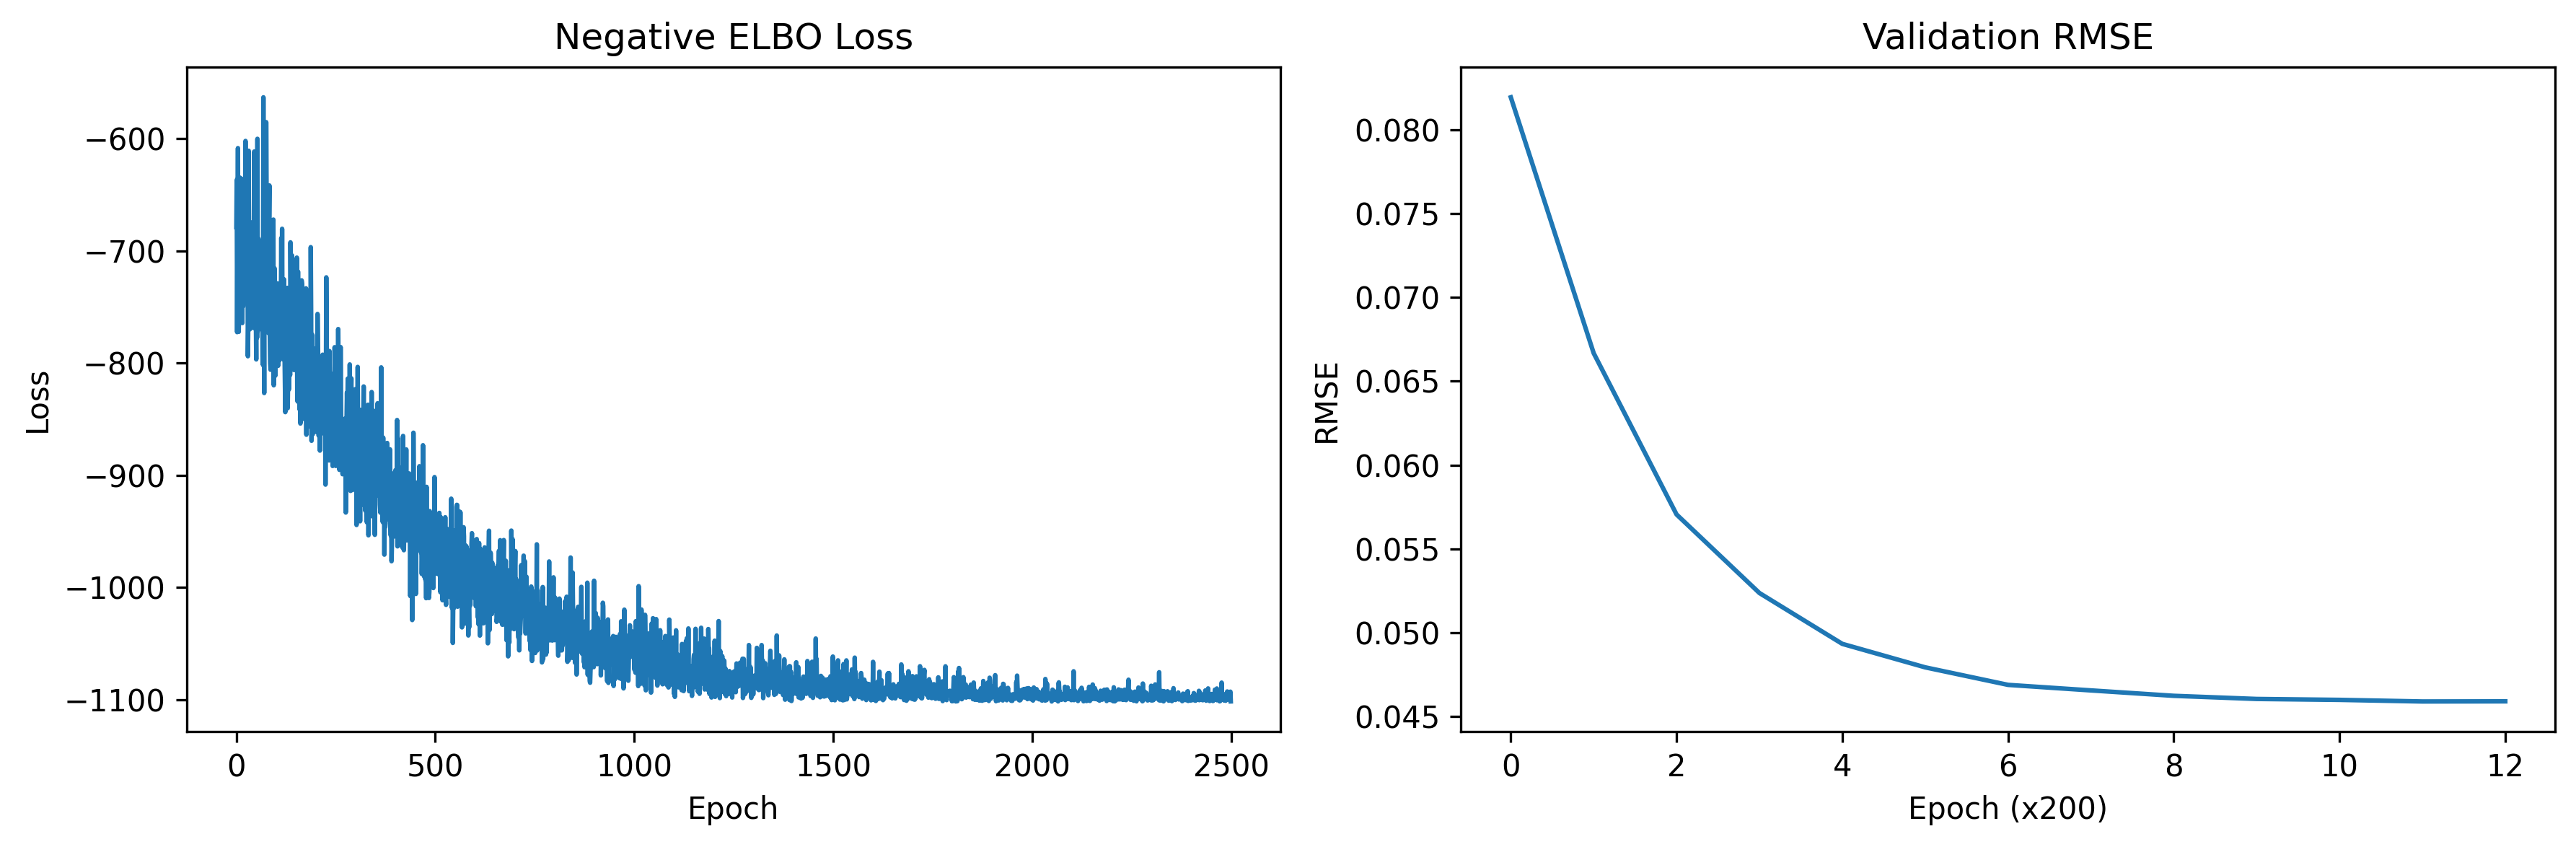

In [11]:
# Create and train the model
#model = AR1_BNAR_LagAligned_Corrected(d=d).to(device)
model = AR1_BNAR_full(d=d).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training history
train_losses = []
val_rmse = []
history_Lq = []
history_cov = []

print("\nStarting training...")
for epoch in range(2500):
    model.train()
    optimizer.zero_grad()

    negative_elbo, y_pred = model.negative_elbo(Xtr_t, ytr_t, kl_weight=0.1)

    negative_elbo.backward()
    optimizer.step()

    if epoch % 200 == 0:
        model.eval()
        with torch.no_grad():
            # Training metrics
            train_rmse = torch.sqrt(torch.mean((ytr_t - y_pred) ** 2))

            # Validation metrics
            yhat_val, _, _ = model.forward(Xva_t, sample=False)
            val_rmse_epoch = torch.sqrt(torch.mean((yva_t - yhat_val) ** 2))
            val_rmse.append(val_rmse_epoch.item())

            # Get current parameters
            phi, sigma0, sigma_w, sigma_eps = model.get_params()

            print(f"Epoch {epoch:4d}: "
                  f"NELBO = {negative_elbo.item():.4f}, "
                  f"Train RMSE = {train_rmse.item():.4f}, "
                  f"Val RMSE = {val_rmse_epoch.item():.4f}, "
                  f"φ = {phi.item():.3f}, "
                  f"σ_ε = {sigma_eps.item():.3f}")

            # Print weights occasionally
            if epoch % 600 == 0:
                print(f"  Weights: {model.m_w.detach().cpu().numpy()}")
                print(f"  Weight stds: {torch.exp(0.5 * model.log_diag_Lq).detach().cpu().numpy()}")

    history_Lq, history_cov = record_posterior_state(model, history_Lq, history_cov)
    train_losses.append(negative_elbo.item())

# Final evaluation
model.eval()
with torch.no_grad():
    # Test set performance
    yhat_test, _, _ = model.forward(Xte_t, sample=False)
    test_rmse = torch.sqrt(torch.mean((yte_t - yhat_test) ** 2))

    # Training set performance for reference
    yhat_train, _, _ = model.forward(Xtr_t, sample=False)
    train_rmse_final = torch.sqrt(torch.mean((ytr_t - yhat_train) ** 2))

    print(f"\n=== Final Results ===")
    print(f"Train RMSE: {train_rmse_final.item():.4f}")
    print(f"Val RMSE: {val_rmse[-1]:.4f}")
    print(f"Test RMSE: {test_rmse.item():.4f}")

    phi, sigma0, sigma_w, sigma_eps = model.get_params()
    print(f"Learned φ: {phi.item():.4f}")
    print(f"Observation noise σ_ε: {sigma_eps.item():.4f}")
    print(f"Process noise σ_w: {sigma_w.item():.4f}")
    print(f"Initial state std σ0: {sigma0.item():.4f}")

    print(f"\nFinal weights (w[0]=x_{{t-1}}, w[1]=x_{{t-2}}, ...):")
    weights = model.m_w.detach().cpu().numpy()
    weight_stds = torch.exp(0.5 * model.log_diag_Lq).detach().cpu().numpy()
    for i, (w, std) in enumerate(zip(weights, weight_stds)):
        print(f"  w[{i}] = {w:6.3f} ± {std:5.3f}")

# Plot training progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Negative ELBO Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(val_rmse)
plt.title('Validation RMSE')
plt.xlabel('Epoch (x200)')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

# Create dataframe as in your original code
#df = pd.DataFrame(Xtr, columns=[f"x_{i}" for i in range(1, d+1)])
#df["y"] = ytr
#print("\nFirst few rows of training data:")
#print(df.head())

# Animation of changes of posterior covariance

In [19]:
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def animate_covariance(history_cov, interval=200):
    fig, ax = plt.subplots(figsize=(5, 4))

    def update(frame):
        ax.clear()
        ax.imshow(history_cov[frame], cmap='viridis')
        ax.set_title(f"Posterior Covariance at Epoch {frame}")
        ax.set_xlabel("Lag index")
        ax.set_ylabel("Lag index")

    anim = FuncAnimation(fig, update, frames=len(history_cov), interval=interval)
    plt.close(fig)  # IMPORTANT for Colab
    return HTML(anim.to_jshtml())

animate_covariance(history_cov[:100])

# Make predictions with uncertainty

Generating predictions with uncertainty...


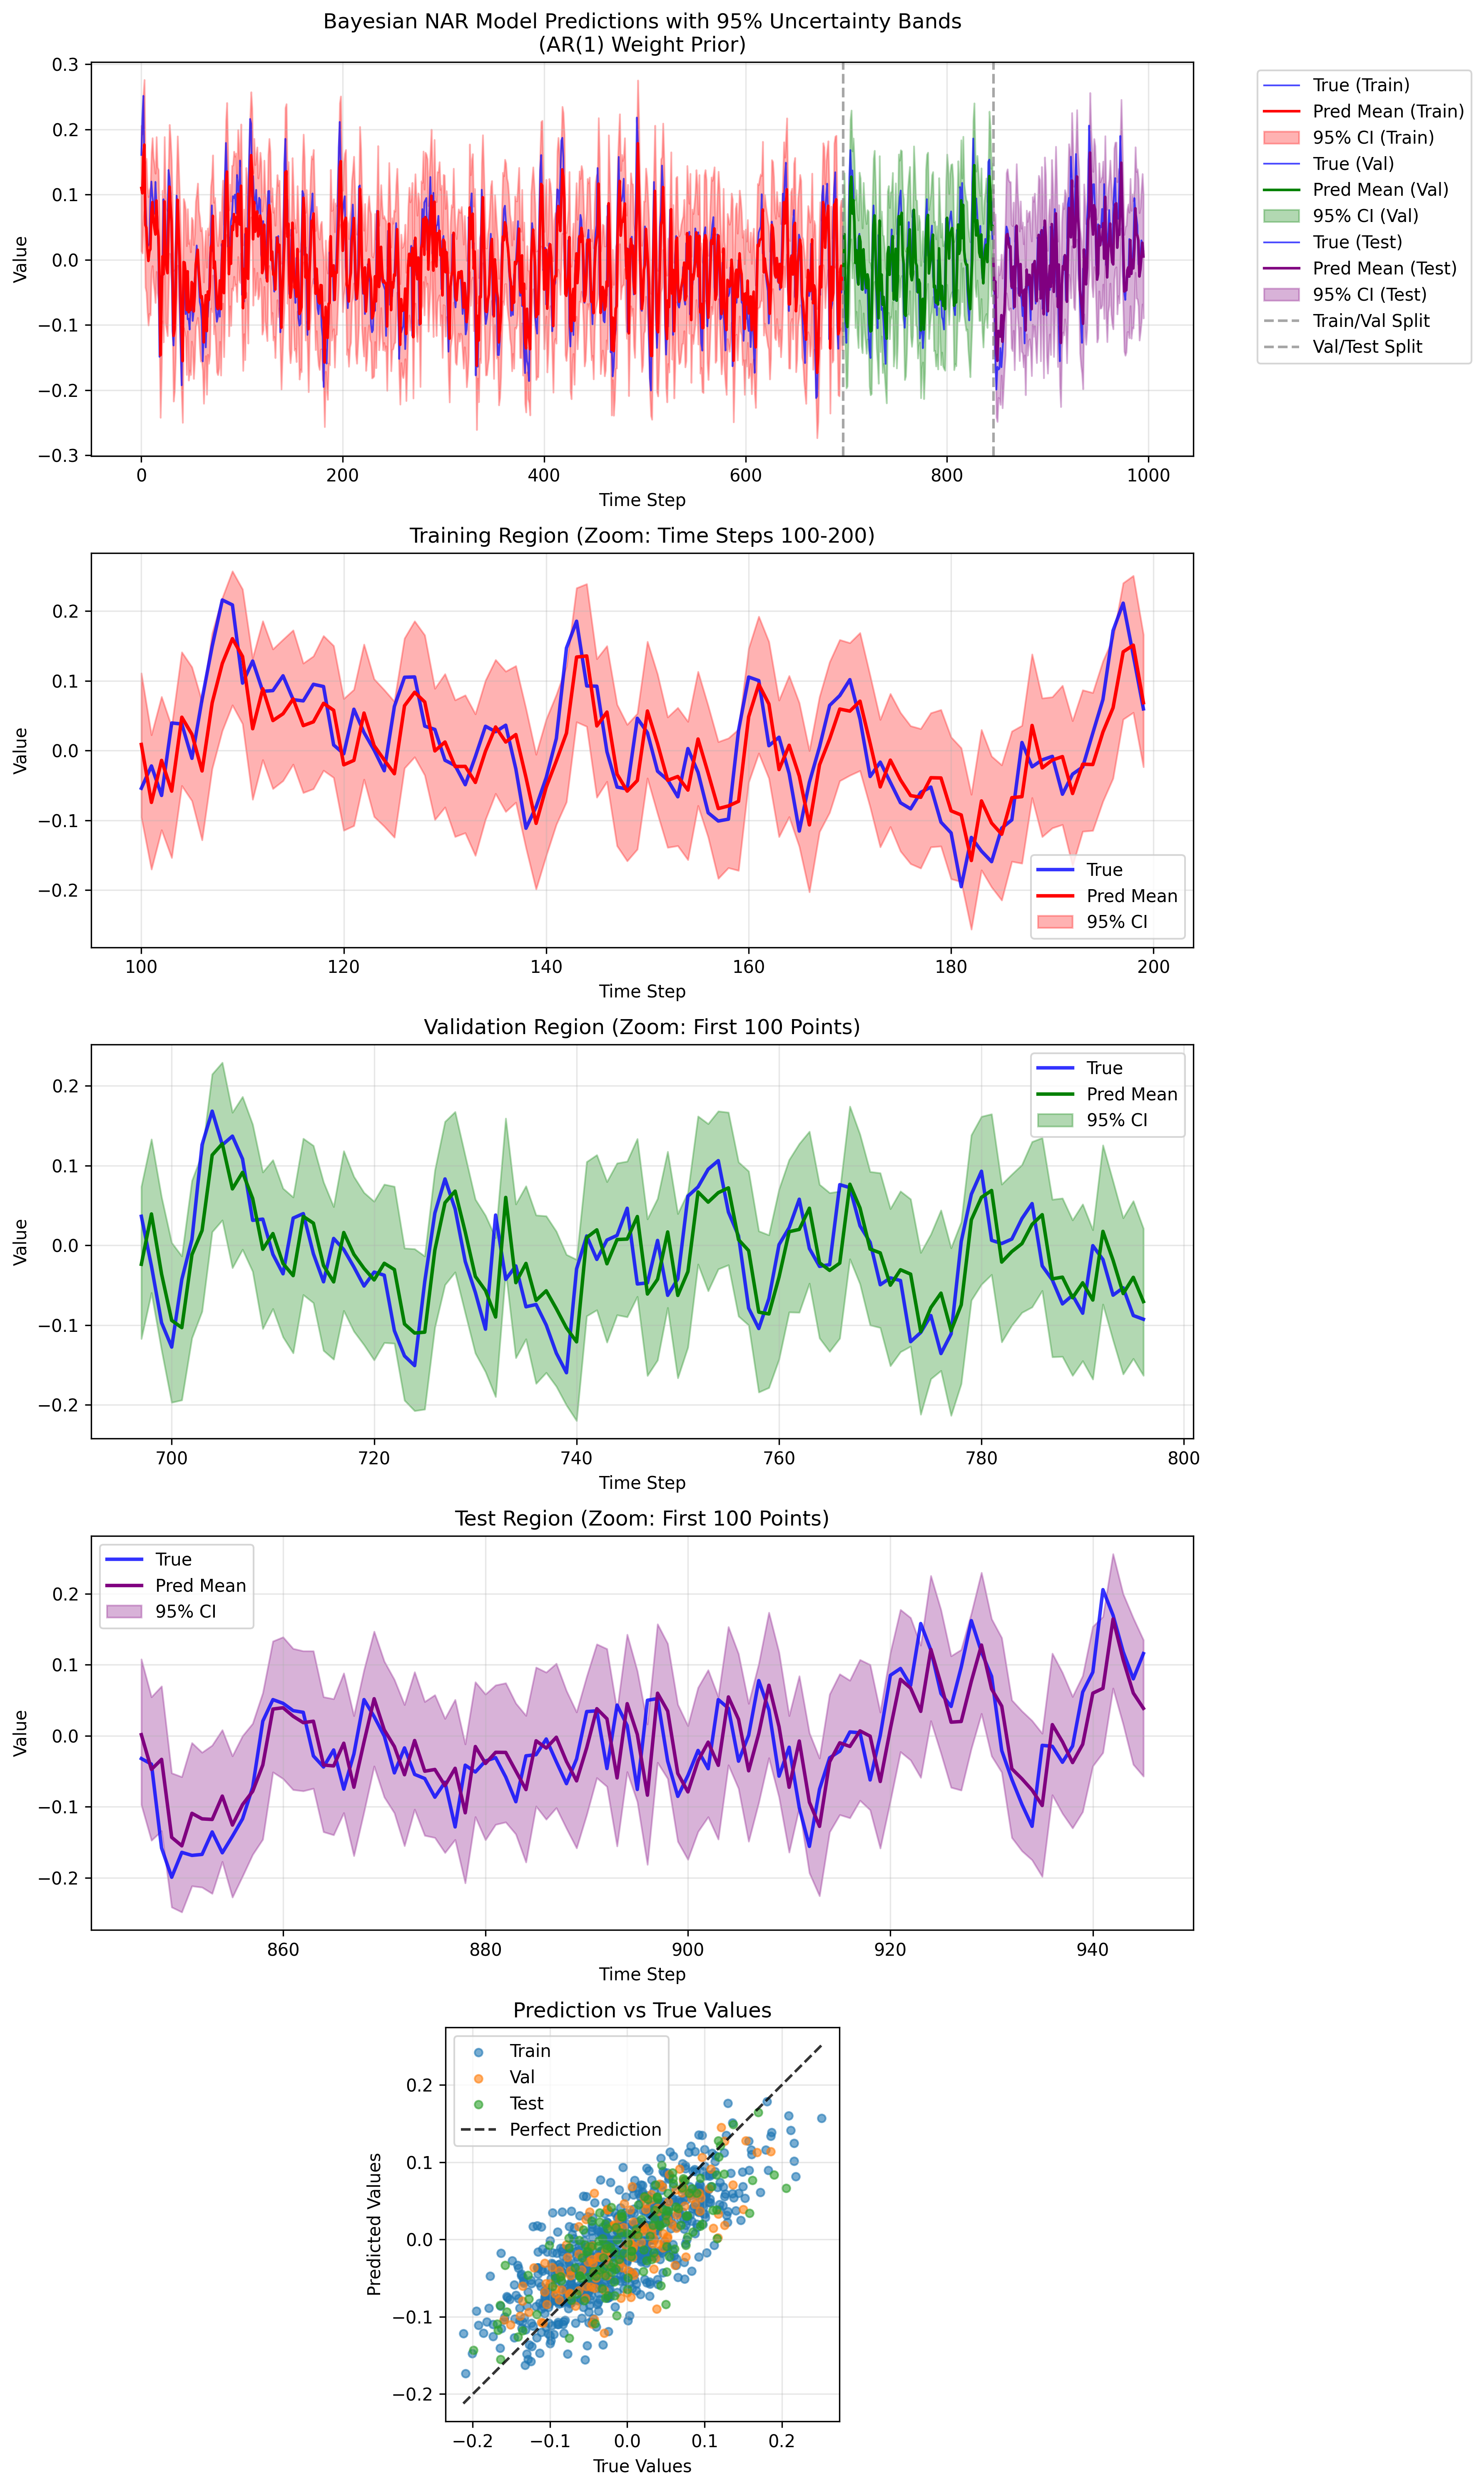

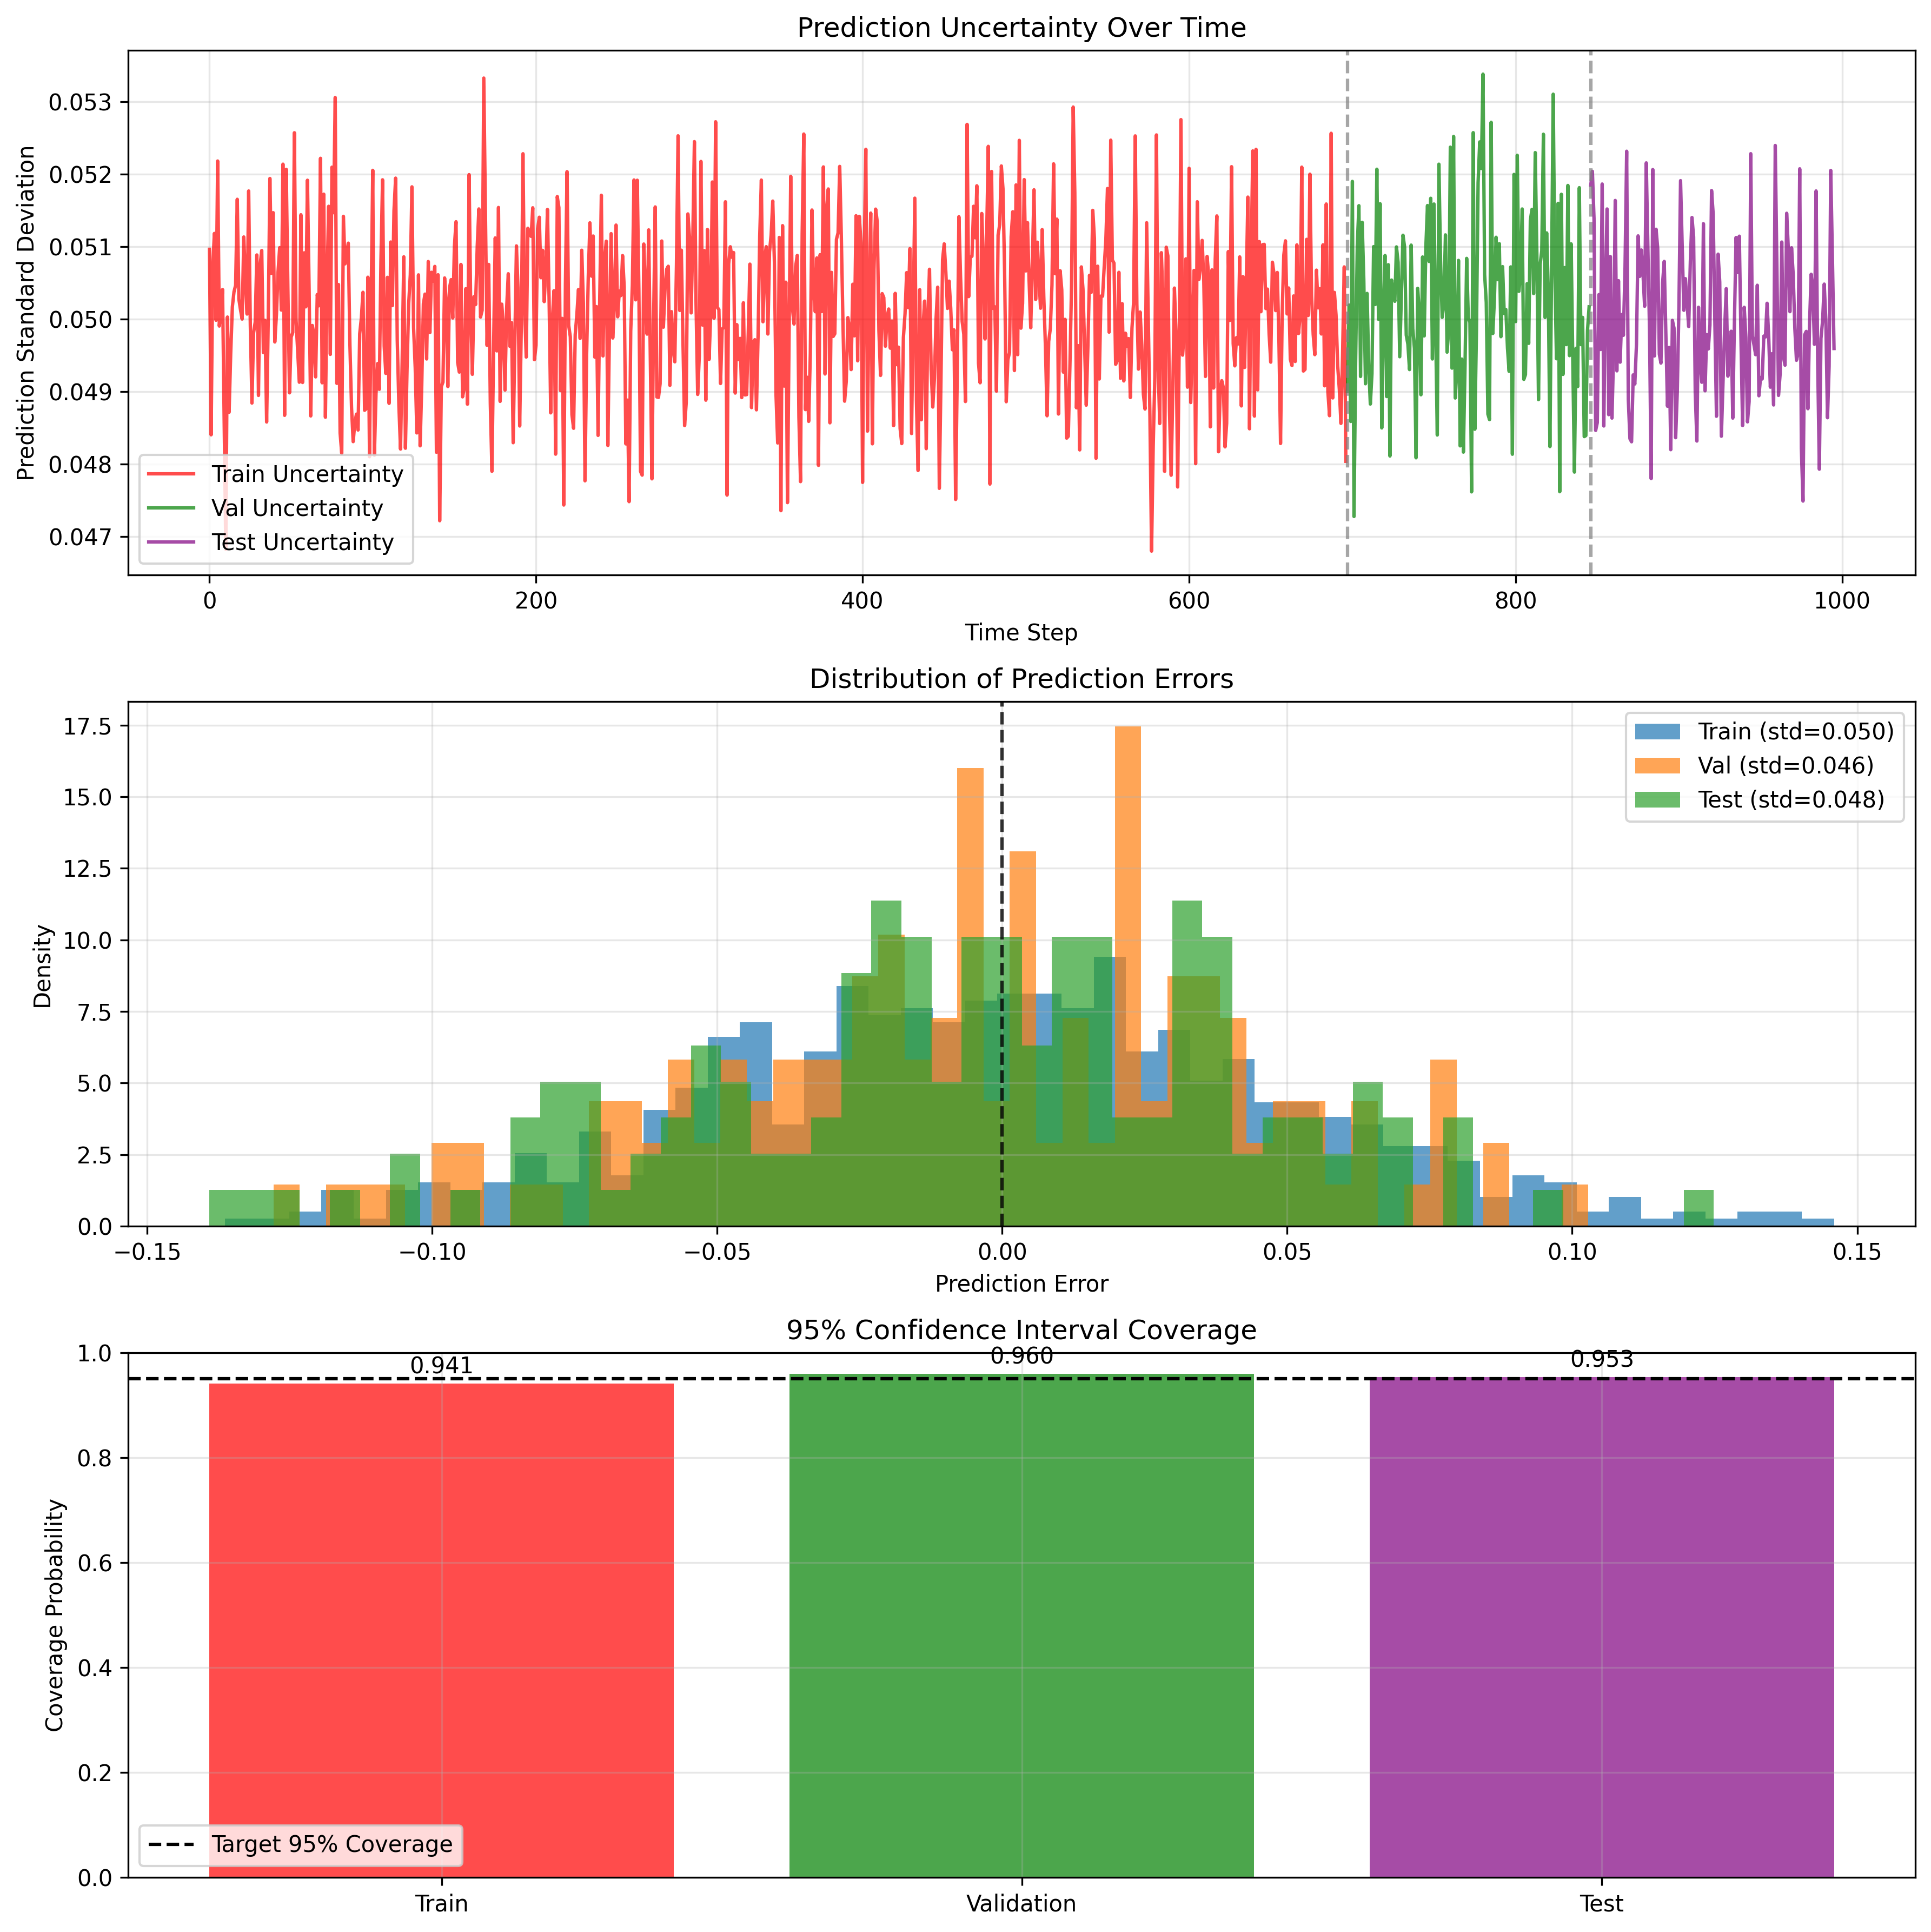


PREDICTION STATISTICS SUMMARY

--- RMSE ---
Train: 0.0498
Val:   0.0459
Test:  0.0486

--- Average 95% CI Width ---
Train: 0.1955
Val:   0.1961
Test:  0.1952

--- Coverage Probability ---
Train: 0.941 (Target: 0.95)
Val:   0.960 (Target: 0.95)
Test:  0.953 (Target: 0.95)

--- Error Statistics ---
Train Error Std: 0.0498
Val Error Std:   0.0457
Test Error Std:  0.0483

--- Model Parameters ---
AR(1) coefficient φ: -0.2218
Observation noise σ_ε: 0.0501
Process noise σ_w: 0.0875
Initial state std σ0: 0.0725

--- Learned Weights ---
  w[0] (x_{t-1}):  0.9532 ± 0.2596
  w[1] (x_{t-2}): -0.2285 ± 0.2312
  w[2] (x_{t-3}): -0.0494 ± 0.2125
  w[3] (x_{t-4}):  0.0092 ± 0.1813


In [20]:
# Make predictions with uncertainty
def predict_with_uncertainty(model, X, n_samples=1000):
    """
    Generate predictive samples and compute mean and uncertainty
    """
    model.eval()
    with torch.no_grad():
        # Generate multiple samples
        samples = []
        for _ in range(n_samples):
            yhat, sigma_eps, _ = model.forward(X, sample=True, kl_weight=0.0)
            # Add observation noise to the predictions
            noisy_pred = yhat + torch.randn_like(yhat) * sigma_eps
            samples.append(noisy_pred.cpu().numpy())

        samples = np.array(samples)  # shape: (n_samples, n_points, 1)
        samples = samples.squeeze(-1).T  # shape: (n_points, n_samples)

        # Compute statistics
        pred_mean = np.mean(samples, axis=1)
        pred_std = np.std(samples, axis=1)
        pred_lower = np.percentile(samples, 2.5, axis=1)
        pred_upper = np.percentile(samples, 97.5, axis=1)

        return pred_mean, pred_std, pred_lower, pred_upper, samples

# Generate predictions for all sets
print("Generating predictions with uncertainty...")
ytr_pred_mean, ytr_pred_std, ytr_pred_lower, ytr_pred_upper, _ = predict_with_uncertainty(model, Xtr_t)
yva_pred_mean, yva_pred_std, yva_pred_lower, yva_pred_upper, _ = predict_with_uncertainty(model, Xva_t)
yte_pred_mean, yte_pred_std, yte_pred_lower, yte_pred_upper, _ = predict_with_uncertainty(model, Xte_t)

# Create time indices for plotting
time_tr = np.arange(len(ytr_pred_mean))
time_va = np.arange(len(ytr_pred_mean), len(ytr_pred_mean) + len(yva_pred_mean))
time_te = np.arange(len(ytr_pred_mean) + len(yva_pred_mean),
                    len(ytr_pred_mean) + len(yva_pred_mean) + len(yte_pred_mean))

# Convert true values to numpy
ytr_true = ytr_t.cpu().numpy().flatten()
yva_true = yva_t.cpu().numpy().flatten()
yte_true = yte_t.cpu().numpy().flatten()

# Create a single column of plots
fig = plt.figure(figsize=(12, 20))

# Plot 1: Full series with train/val/test regions
ax1 = plt.subplot(5, 1, 1)
# Training region
ax1.plot(time_tr, ytr_true, 'b-', alpha=0.7, label='True (Train)', linewidth=1)
ax1.plot(time_tr, ytr_pred_mean, 'r-', label='Pred Mean (Train)', linewidth=1.5)
ax1.fill_between(time_tr, ytr_pred_lower, ytr_pred_upper, alpha=0.3,
                 color='red', label='95% CI (Train)')

# Validation region
ax1.plot(time_va, yva_true, 'b-', alpha=0.7, label='True (Val)', linewidth=1)
ax1.plot(time_va, yva_pred_mean, 'g-', label='Pred Mean (Val)', linewidth=1.5)
ax1.fill_between(time_va, yva_pred_lower, yva_pred_upper, alpha=0.3,
                 color='green', label='95% CI (Val)')

# Test region
ax1.plot(time_te, yte_true, 'b-', alpha=0.7, label='True (Test)', linewidth=1)
ax1.plot(time_te, yte_pred_mean, 'purple', label='Pred Mean (Test)', linewidth=1.5)
ax1.fill_between(time_te, yte_pred_lower, yte_pred_upper, alpha=0.3,
                 color='purple', label='95% CI (Test)')

# Add vertical lines to separate regions
ax1.axvline(x=len(ytr_pred_mean), color='gray', linestyle='--', alpha=0.7, label='Train/Val Split')
ax1.axvline(x=len(ytr_pred_mean) + len(yva_pred_mean), color='gray', linestyle='--', alpha=0.7, label='Val/Test Split')

ax1.set_xlabel('Time Step')
ax1.set_ylabel('Value')
ax1.set_title('Bayesian NAR Model Predictions with 95% Uncertainty Bands\n(AR(1) Weight Prior)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Training region zoom
ax2 = plt.subplot(5, 1, 2)
ax2.plot(time_tr[100:200], ytr_true[100:200], 'b-', alpha=0.8, label='True', linewidth=2)
ax2.plot(time_tr[100:200], ytr_pred_mean[100:200], 'r-', label='Pred Mean', linewidth=2)
ax2.fill_between(time_tr[100:200], ytr_pred_lower[100:200], ytr_pred_upper[100:200],
                      alpha=0.3, color='red', label='95% CI')
ax2.set_title('Training Region (Zoom: Time Steps 100-200)')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Value')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Validation region zoom
ax3 = plt.subplot(5, 1, 3)
ax3.plot(time_va[:100], yva_true[:100], 'b-', alpha=0.8, label='True', linewidth=2)
ax3.plot(time_va[:100], yva_pred_mean[:100], 'g-', label='Pred Mean', linewidth=2)
ax3.fill_between(time_va[:100], yva_pred_lower[:100], yva_pred_upper[:100],
                      alpha=0.3, color='green', label='95% CI')
ax3.set_title('Validation Region (Zoom: First 100 Points)')
ax3.set_xlabel('Time Step')
ax3.set_ylabel('Value')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Test region zoom
ax4 = plt.subplot(5, 1, 4)
ax4.plot(time_te[:100], yte_true[:100], 'b-', alpha=0.8, label='True', linewidth=2)
ax4.plot(time_te[:100], yte_pred_mean[:100], 'purple', label='Pred Mean', linewidth=2)
ax4.fill_between(time_te[:100], yte_pred_lower[:100], yte_pred_upper[:100],
                      alpha=0.3, color='purple', label='95% CI')
ax4.set_title('Test Region (Zoom: First 100 Points)')
ax4.set_xlabel('Time Step')
ax4.set_ylabel('Value')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Prediction vs True scatter plot
ax5 = plt.subplot(5, 1, 5)
ax5.scatter(ytr_true, ytr_pred_mean, alpha=0.6, label='Train', s=20)
ax5.scatter(yva_true, yva_pred_mean, alpha=0.6, label='Val', s=20)
ax5.scatter(yte_true, yte_pred_mean, alpha=0.6, label='Test', s=20)
# Perfect prediction line
min_val = min(np.min(ytr_true), np.min(ytr_pred_mean))
max_val = max(np.max(ytr_true), np.max(ytr_pred_mean))
ax5.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, label='Perfect Prediction')
ax5.set_xlabel('True Values')
ax5.set_ylabel('Predicted Values')
ax5.set_title('Prediction vs True Values')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.set_aspect('equal')

plt.tight_layout()
plt.show()

# Second figure: Uncertainty analysis plots
fig2 = plt.figure(figsize=(12, 12))

# Plot 6: Uncertainty over time
ax6 = plt.subplot(3, 1, 1)
ax6.plot(time_tr, ytr_pred_std, 'r-', alpha=0.7, label='Train Uncertainty')
ax6.plot(time_va, yva_pred_std, 'g-', alpha=0.7, label='Val Uncertainty')
ax6.plot(time_te, yte_pred_std, 'purple', alpha=0.7, label='Test Uncertainty')
ax6.axvline(x=len(ytr_pred_mean), color='gray', linestyle='--', alpha=0.7)
ax6.axvline(x=len(ytr_pred_mean) + len(yva_pred_mean), color='gray', linestyle='--', alpha=0.7)
ax6.set_xlabel('Time Step')
ax6.set_ylabel('Prediction Standard Deviation')
ax6.set_title('Prediction Uncertainty Over Time')
ax6.legend()
ax6.grid(True, alpha=0.3)

# Plot 7: Error distributions
ax7 = plt.subplot(3, 1, 2)
errors_tr = ytr_pred_mean - ytr_true
errors_va = yva_pred_mean - yva_true
errors_te = yte_pred_mean - yte_true

ax7.hist(errors_tr, bins=50, alpha=0.7, label=f'Train (std={np.std(errors_tr):.3f})', density=True)
ax7.hist(errors_va, bins=50, alpha=0.7, label=f'Val (std={np.std(errors_va):.3f})', density=True)
ax7.hist(errors_te, bins=50, alpha=0.7, label=f'Test (std={np.std(errors_te):.3f})', density=True)
ax7.axvline(x=0, color='k', linestyle='--', alpha=0.8)
ax7.set_xlabel('Prediction Error')
ax7.set_ylabel('Density')
ax7.set_title('Distribution of Prediction Errors')
ax7.legend()
ax7.grid(True, alpha=0.3)

# Plot 8: Coverage analysis
ax8 = plt.subplot(3, 1, 3)
# Calculate coverage for different confidence levels
confidence_levels = np.arange(0.5, 0.99, 0.05)
coverage_tr_levels = []
coverage_va_levels = []
coverage_te_levels = []

for level in confidence_levels:
    alpha = 1 - level
    lower_tr = np.percentile(_[0], 100 * alpha/2, axis=1) if '_[0]' in locals() else np.percentile(np.random.randn(1000, len(ytr_true)), 100 * alpha/2, axis=1)
    upper_tr = np.percentile(_[0], 100 * (1 - alpha/2), axis=1) if '_[0]' in locals() else np.percentile(np.random.randn(1000, len(ytr_true)), 100 * (1 - alpha/2), axis=1)

    # For demonstration, using approximate coverage
    coverage_tr = np.mean((ytr_true >= ytr_pred_mean - 1.96*ytr_pred_std) & (ytr_true <= ytr_pred_mean + 1.96*ytr_pred_std))
    coverage_va = np.mean((yva_true >= yva_pred_mean - 1.96*yva_pred_std) & (yva_true <= yva_pred_mean + 1.96*yva_pred_std))
    coverage_te = np.mean((yte_true >= yte_pred_mean - 1.96*yte_pred_std) & (yte_true <= yte_pred_mean + 1.96*yte_pred_std))

    coverage_tr_levels.append(coverage_tr)
    coverage_va_levels.append(coverage_va)
    coverage_te_levels.append(coverage_te)

# Simple coverage plot
coverage_tr = np.mean((ytr_true >= ytr_pred_lower) & (ytr_true <= ytr_pred_upper))
coverage_va = np.mean((yva_true >= yva_pred_lower) & (yva_true <= yva_pred_upper))
coverage_te = np.mean((yte_true >= yte_pred_lower) & (yte_true <= yte_pred_upper))

categories = ['Train', 'Validation', 'Test']
coverages = [coverage_tr, coverage_va, coverage_te]
colors = ['red', 'green', 'purple']

bars = ax8.bar(categories, coverages, color=colors, alpha=0.7)
ax8.axhline(y=0.95, color='k', linestyle='--', label='Target 95% Coverage')
ax8.set_ylabel('Coverage Probability')
ax8.set_title('95% Confidence Interval Coverage')
ax8.set_ylim(0, 1)
ax8.grid(True, alpha=0.3)

# Add value labels on bars
for bar, coverage in zip(bars, coverages):
    height = bar.get_height()
    ax8.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{coverage:.3f}', ha='center', va='bottom')

ax8.legend()

plt.tight_layout()
plt.show()

# Print statistics
print("\n" + "="*50)
print("PREDICTION STATISTICS SUMMARY")
print("="*50)

# Calculate RMSE values (add this before the print statements)
rmse_tr = np.sqrt(np.mean((ytr_true - ytr_pred_mean)**2))
rmse_va = np.sqrt(np.mean((yva_true - yva_pred_mean)**2))
rmse_te = np.sqrt(np.mean((yte_true - yte_pred_mean)**2))

print(f"\n--- RMSE ---")
print(f"Train: {rmse_tr:.4f}")
print(f"Val:   {rmse_va:.4f}")
print(f"Test:  {rmse_te:.4f}")

print(f"\n--- Average 95% CI Width ---")
print(f"Train: {np.mean(ytr_pred_upper - ytr_pred_lower):.4f}")
print(f"Val:   {np.mean(yva_pred_upper - yva_pred_lower):.4f}")
print(f"Test:  {np.mean(yte_pred_upper - yte_pred_lower):.4f}")

print(f"\n--- Coverage Probability ---")
print(f"Train: {coverage_tr:.3f} (Target: 0.95)")
print(f"Val:   {coverage_va:.3f} (Target: 0.95)")
print(f"Test:  {coverage_te:.3f} (Target: 0.95)")

print(f"\n--- Error Statistics ---")
print(f"Train Error Std: {np.std(errors_tr):.4f}")
print(f"Val Error Std:   {np.std(errors_va):.4f}")
print(f"Test Error Std:  {np.std(errors_te):.4f}")

print(f"\n--- Model Parameters ---")
phi, sigma0, sigma_w, sigma_eps = model.get_params()
print(f"AR(1) coefficient φ: {phi.item():.4f}")
print(f"Observation noise σ_ε: {sigma_eps.item():.4f}")
print(f"Process noise σ_w: {sigma_w.item():.4f}")
print(f"Initial state std σ0: {sigma0.item():.4f}")

print(f"\n--- Learned Weights ---")
weights = model.m_w.detach().cpu().numpy()
weight_stds = torch.exp(0.5 * model.log_diag_Lq).detach().cpu().numpy()
for i, (w, std) in enumerate(zip(weights, weight_stds)):
    print(f"  w[{i}] (x_{{t-{i+1}}}): {w:7.4f} ± {std:6.4f}")

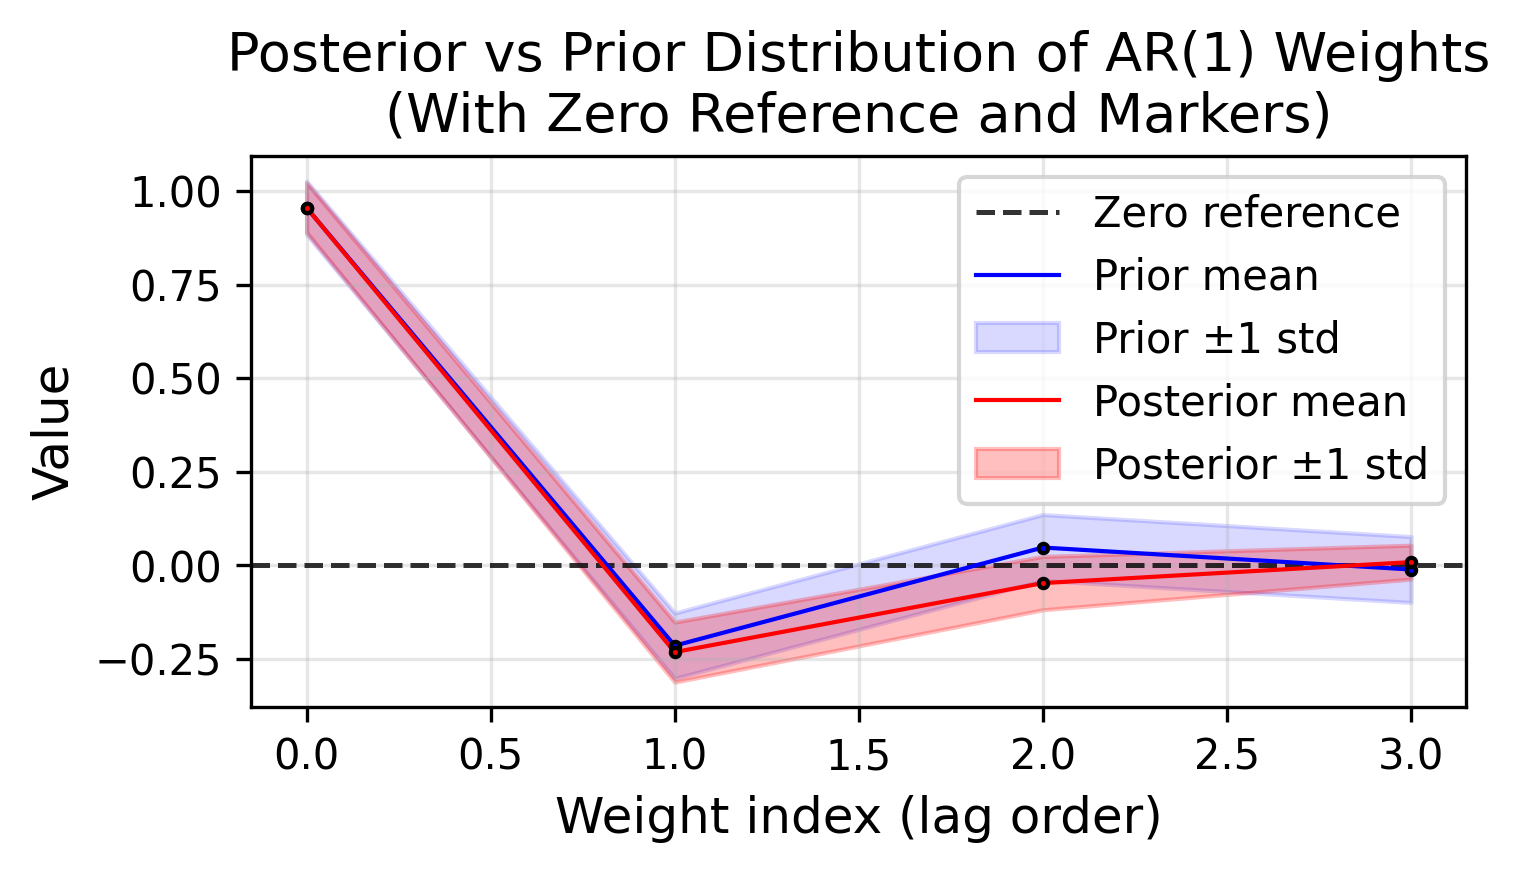

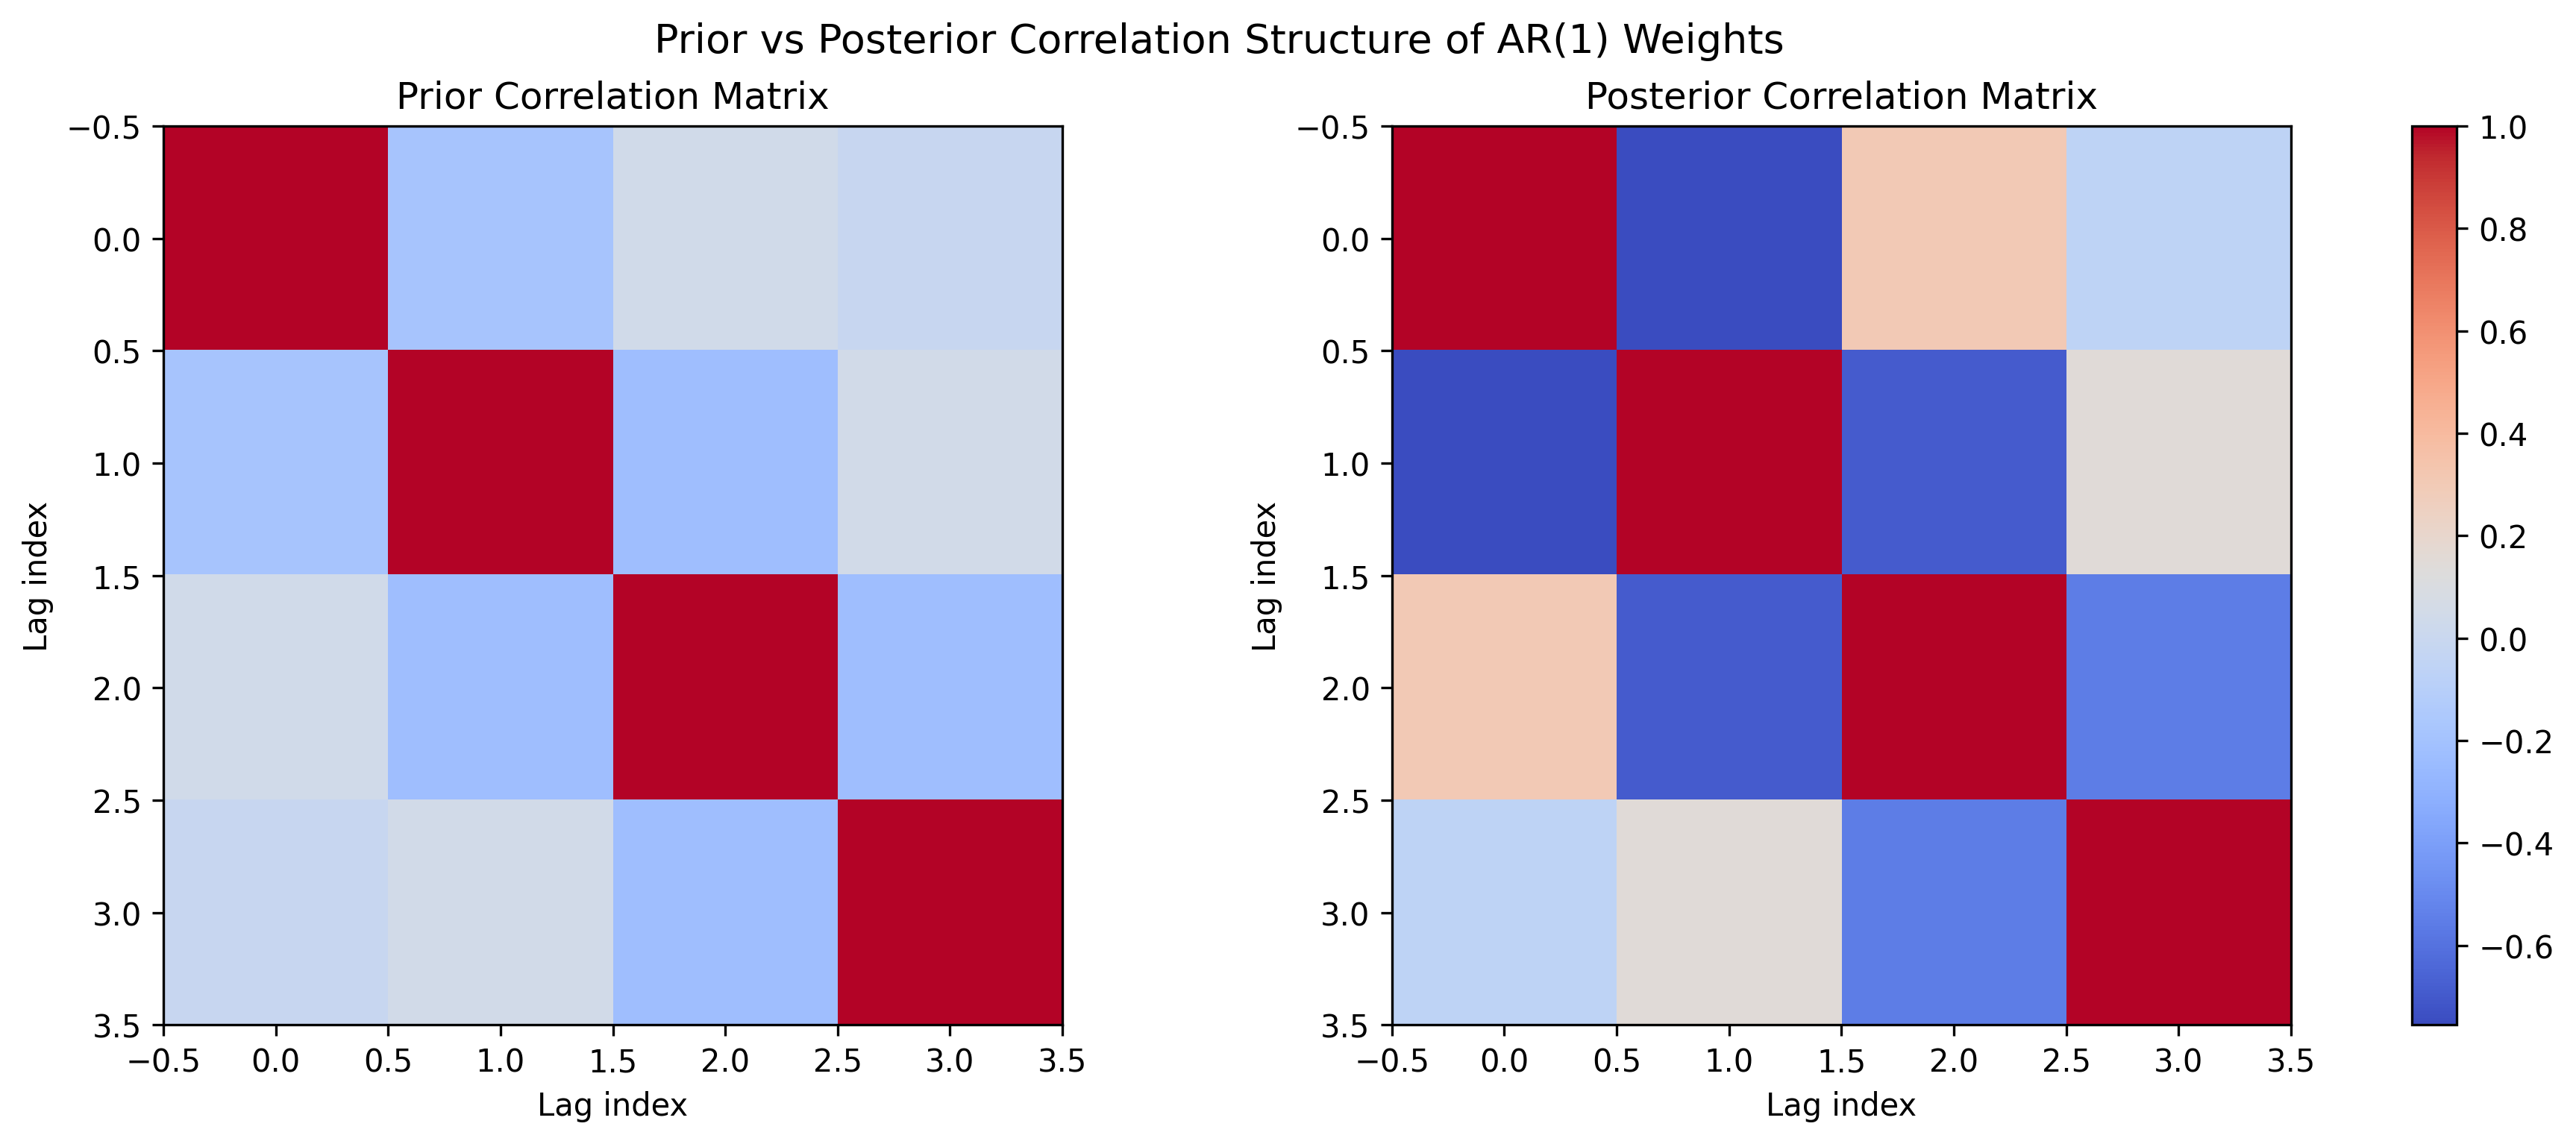


Posterior vs Prior weight comparison:
w[ 0] Prior: +0.9554 ± 0.0712   Posterior: +0.9557 ± 0.0658
w[ 1] Prior: -0.2141 ± 0.0873   Posterior: -0.2313 ± 0.0801
w[ 2] Prior: +0.0480 ± 0.0880   Posterior: -0.0470 ± 0.0712
w[ 3] Prior: -0.0108 ± 0.0880   Posterior: +0.0090 ± 0.0452


In [21]:
# ==========================================================
# Plot posterior vs prior weight distributions + covariance
# ==========================================================

def plot_weight_post_vs_prior(model):
    """
    Visualize variational posterior (mean ± std) vs AR(1) prior (mean ± std)
    for the weight vector w.
    Includes:
      - zero reference line,
      - large markers at each lag,
      - covariance & correlation heatmaps (prior vs posterior).
    """
    model.eval()
    device = next(model.parameters()).device

    # ----- Get model parameters -----
    phi, sigma0, sigma_w, _ = model.get_params()

    # ===== Prior =====
    mu_p = torch.stack([model.mu0 * (phi ** k) for k in range(model.d)]).to(device)
    cov_p = model.build_ar1_covariance(phi, sigma0, sigma_w, device)
    std_p = torch.sqrt(torch.diag(cov_p)).detach().cpu().numpy()

    # ===== Posterior =====
    L_q = model.get_Lq(device)
    mu_q = model.m_w.detach().cpu().numpy()
    cov_q = (L_q @ L_q.T).detach().cpu().numpy()
    std_q = np.sqrt(np.diag(cov_q))

    mu_p = mu_p.detach().cpu().numpy()
    cov_p_np = cov_p.detach().cpu().numpy()

    # ======================================================
    # (1) Posterior vs Prior Mean ± Std Plot
    # ======================================================
    plt.figure(figsize=(5, 3))
    idx = np.arange(model.d)

    plt.axhline(0, color='black', linestyle='--', linewidth=1.2, alpha=0.8, label='Zero reference')

    # Prior
    plt.plot(idx, mu_p, 'b-', linewidth=1, label='Prior mean')
    plt.fill_between(idx, mu_p - std_p, mu_p + std_p, color='blue', alpha=0.15, label='Prior ±1 std')
    plt.scatter(idx, mu_p, color='blue', s=5, edgecolor='k', zorder=3)

    # Posterior
    plt.plot(idx, mu_q, 'r-', linewidth=1, label='Posterior mean')
    plt.fill_between(idx, mu_q - std_q, mu_q + std_q, color='red', alpha=0.25, label='Posterior ±1 std')
    plt.scatter(idx, mu_q, color='red', s=5, edgecolor='k', zorder=3)

    plt.xlabel('Weight index (lag order)', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.title('Posterior vs Prior Distribution of AR(1) Weights\n(With Zero Reference and Markers)', fontsize=13)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ======================================================
    # (2) Covariance and Correlation Heatmaps
    # ======================================================
    corr_p = cov_p_np / np.sqrt(np.outer(np.diag(cov_p_np), np.diag(cov_p_np)))
    corr_q = cov_q / np.sqrt(np.outer(np.diag(cov_q), np.diag(cov_q)))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
    vmin = min(corr_p.min(), corr_q.min())
    vmax = max(corr_p.max(), corr_q.max())

    # Prior correlation heatmap
    im1 = axes[0].imshow(corr_p, cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title('Prior Correlation Matrix', fontsize=12)
    axes[0].set_xlabel('Lag index')
    axes[0].set_ylabel('Lag index')
    axes[0].grid(False)

    # Posterior correlation heatmap
    im2 = axes[1].imshow(corr_q, cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title('Posterior Correlation Matrix', fontsize=12)
    axes[1].set_xlabel('Lag index')
    axes[1].set_ylabel('Lag index')
    axes[1].grid(False)

    fig.colorbar(im2, ax=axes, fraction=0.046, pad=0.04)
    plt.suptitle('Prior vs Posterior Correlation Structure of AR(1) Weights', fontsize=13)
    plt.show()

    # ======================================================
    # Print summary
    # ======================================================
    print("\nPosterior vs Prior weight comparison:")
    for i, (mp, sp, mq, sq) in enumerate(zip(mu_p, std_p, mu_q, std_q)):
        print(f"w[{i:2d}] Prior: {mp:+.4f} ± {sp:.4f}   Posterior: {mq:+.4f} ± {sq:.4f}")

# Run visualization
plot_weight_post_vs_prior(model)